In [273]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from datetime import date
import warnings
warnings.simplefilter('ignore')



In [274]:
df = pd.read_csv('cycling_counts_by_day.csv')

In [275]:
df.head()

,datetime,Tamaki Drive EB
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0


In [276]:
df.tail()

,datetime,Tamaki Drive EB
2887,2018-05-27,235.0
2888,2018-05-28,709.0
2889,2018-05-29,859.0
2890,2018-05-30,787.0
2891,2018-05-31,749.0


In [277]:
df.shape

(2892, 2)

In [278]:
df.dtypes

datetime            object
Tamaki Drive EB    float64
dtype: object

In [279]:
df['datetime'] = pd.to_datetime(df['datetime'])



In [280]:
df.set_index('datetime', inplace=True)



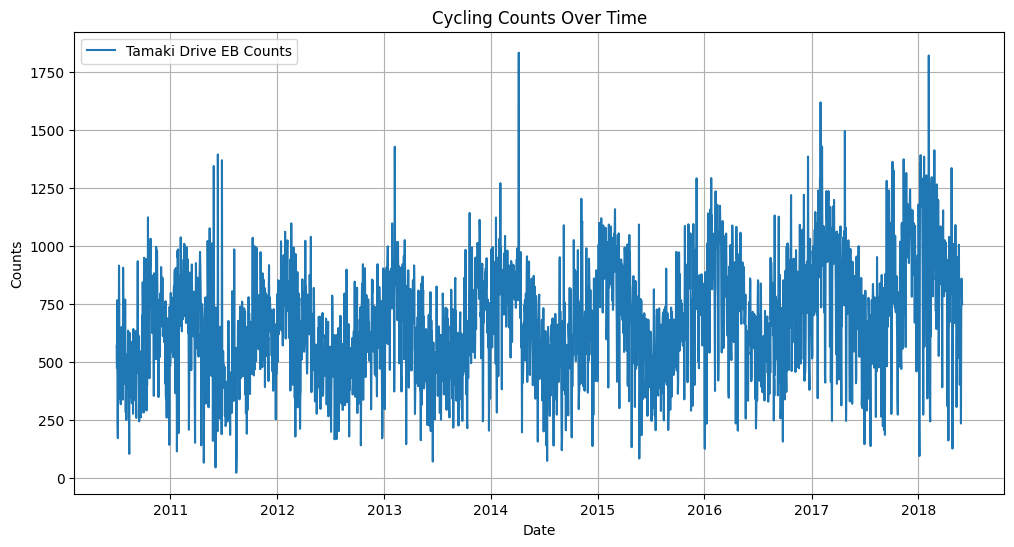

In [281]:

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Tamaki Drive EB'], label='Tamaki Drive EB Counts')
plt.title('Cycling Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.show()


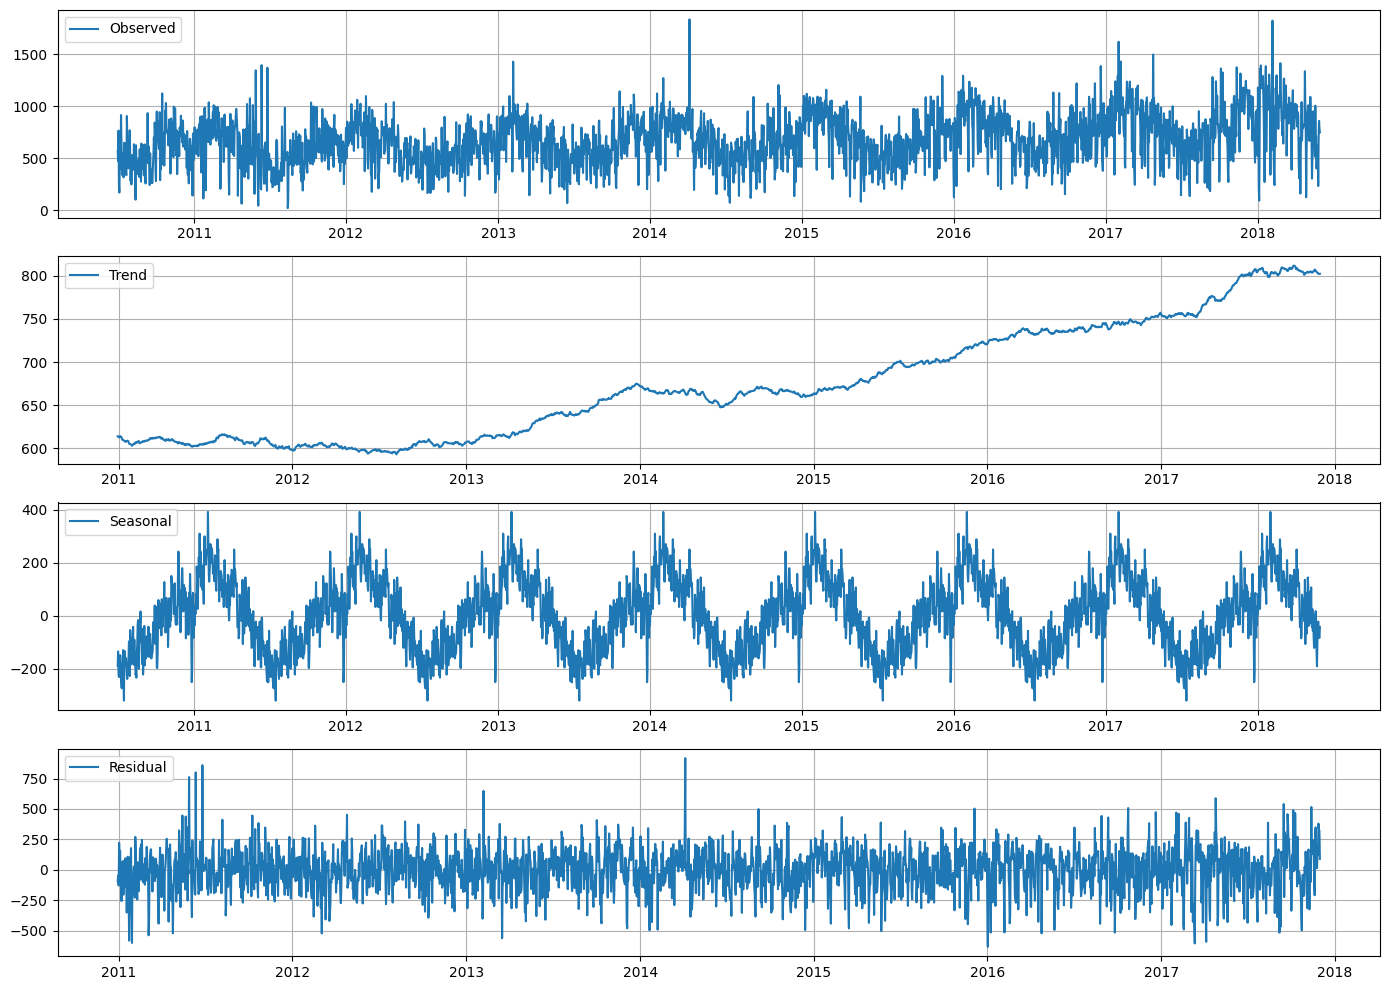

In [282]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Tamaki Drive EB'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.grid()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


The time series decomposition reveals:

Observed: The original data.
Trend: The long-term direction of the data.
Seasonal: Regular patterns repeating over a specific period (e.g yearly).
Residual: The remaining variations after removing the trend and seasonal components.

In [283]:
# Inspect the columns in the dataframe to verify available column names
df_columns = df.columns

df_columns


Index(['Tamaki Drive EB'], dtype='object')

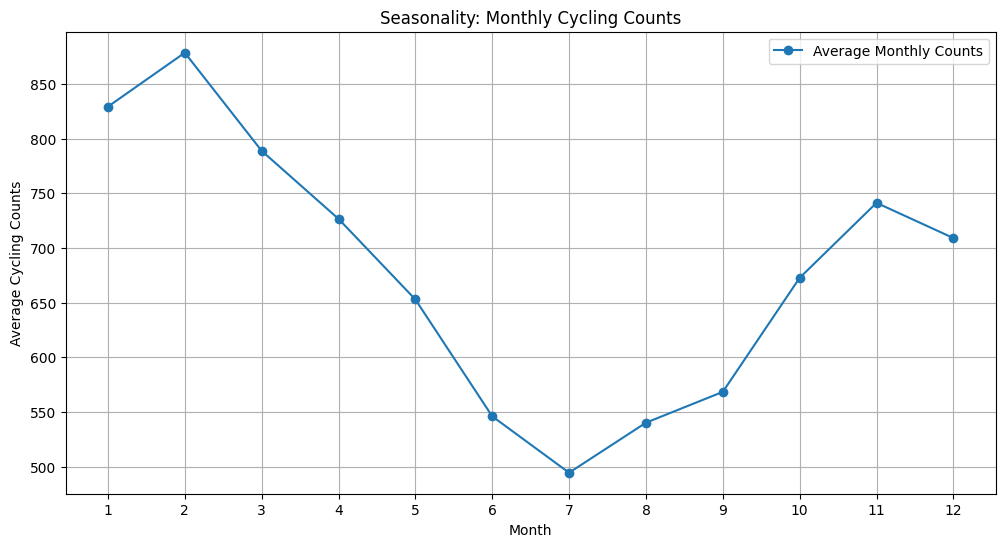

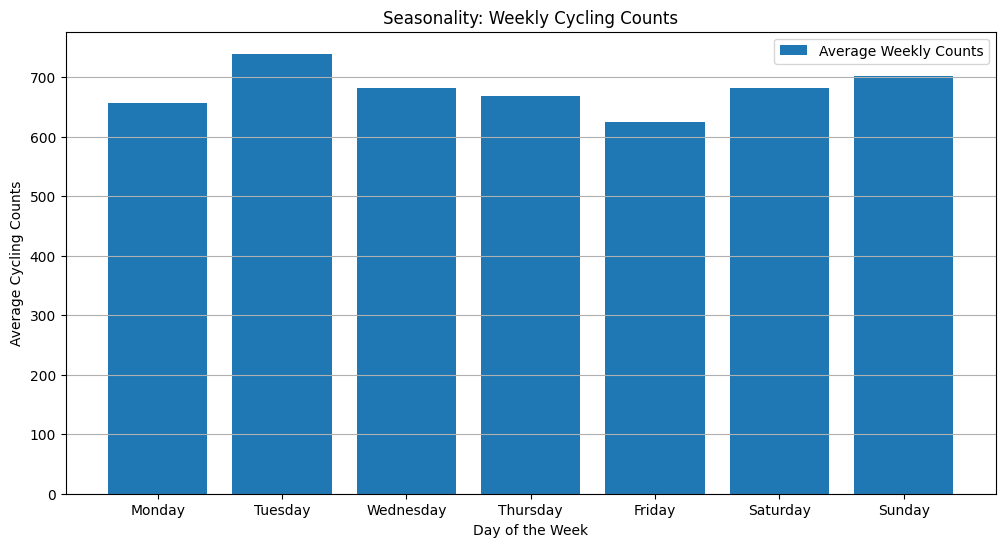

In [284]:
# Extract year, month, and day of the week from the index for seasonality analysis
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_week'] = df.index.day_name()

# Aggregate data by month to identify monthly patterns
monthly_data = df.groupby('month')['Tamaki Drive EB'].mean()

# Aggregate data by day of the week to identify weekly patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_data = df.groupby('day_of_week')['Tamaki Drive EB'].mean()
weekly_data = weekly_data.reindex(day_order)

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, marker='o', label='Average Monthly Counts')
plt.title('Seasonality: Monthly Cycling Counts')
plt.xlabel('Month')
plt.ylabel('Average Cycling Counts')
plt.xticks(range(1, 13))
plt.grid()
plt.legend()
plt.show()

# Plot weekly trends
plt.figure(figsize=(12, 6))
plt.bar(weekly_data.index, weekly_data, label='Average Weekly Counts')
plt.title('Seasonality: Weekly Cycling Counts')
plt.xlabel('Day of the Week')
plt.ylabel('Average Cycling Counts')
plt.grid(axis='y')
plt.legend()
plt.show()


In [285]:
forecast_df = df.reset_index()[['datetime', 'Tamaki Drive EB']].rename(columns={'datetime': 'ds', 'Tamaki Drive EB': 'y'})

forecast_df.head()

,ds,y
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0


In [286]:
test_forcast = forecast_df[forecast_df['ds']>'2018-01-01'].copy()
train_forcast = forecast_df[forecast_df['ds']<='2018-01-01'].copy()

In [287]:
print(len(train_forcast), len(test_forcast))


2742 150


In [288]:
train_forcast.tail()

,ds,y
2737,2017-12-28,940.0
2738,2017-12-29,811.0
2739,2017-12-30,960.0
2740,2017-12-31,914.0
2741,2018-01-01,522.0


In [289]:
train_forcast.head()

,ds,y
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0


Prophet Forcasting 

In [290]:
%%time
m = Prophet()
m.fit(train_forcast)

12:34:49 - cmdstanpy - INFO - Chain [1] start processing
12:34:49 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 91.3 ms, sys: 13 ms, total: 104 ms
Wall time: 210 ms


In [291]:
forecast_days = 200
future = m.make_future_dataframe(periods=forecast_days, freq='D' )
future

,ds
0,2010-07-01
1,2010-07-02
2,2010-07-03
3,2010-07-04
4,2010-07-05
...,...
2937,2018-07-16
2938,2018-07-17
2939,2018-07-18
2940,2018-07-19


In [292]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2937,2018-07-16,645.244418,427.115726,889.624800
2938,2018-07-17,733.341851,484.717603,954.529597
2939,2018-07-18,680.242443,434.968654,927.136382
2940,2018-07-19,672.616218,427.655909,901.645177
2941,2018-07-20,634.253638,380.979605,864.075117


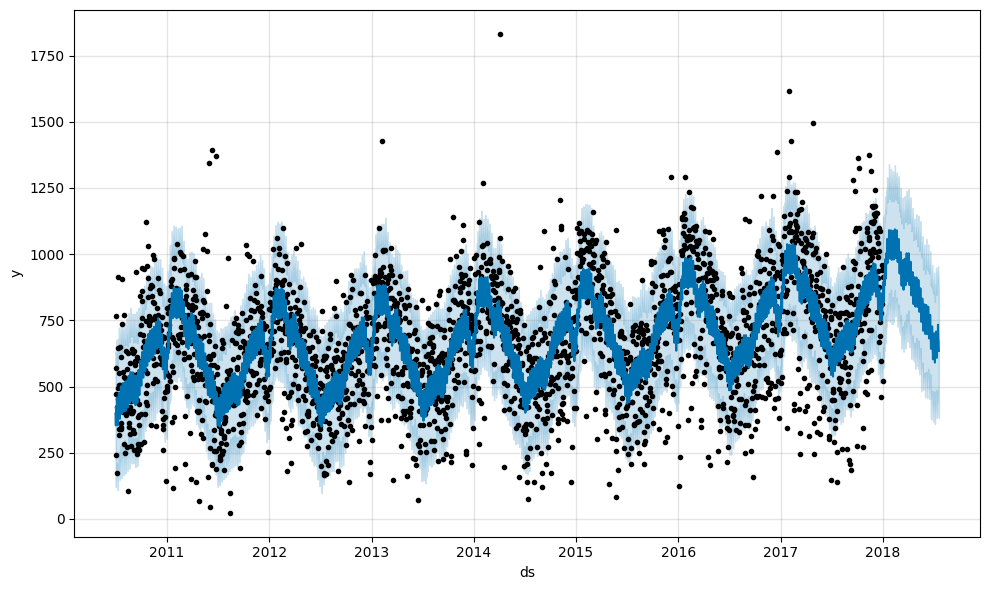

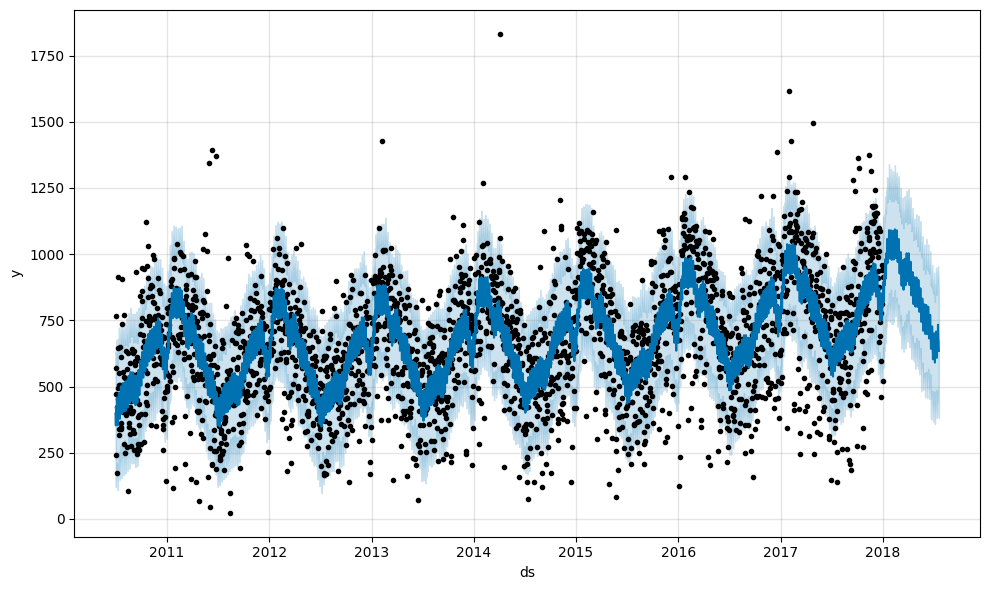

In [293]:
m.plot(forecast)


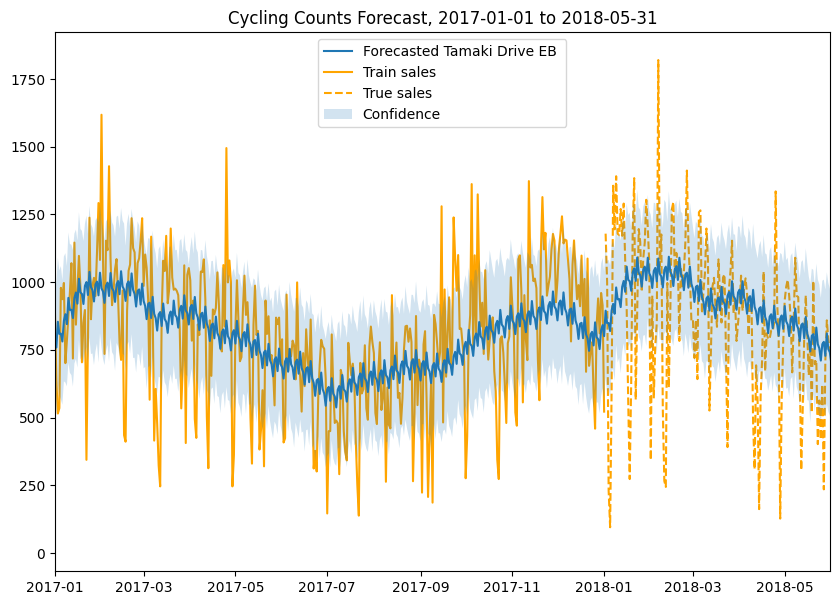

In [294]:
train_data_plot = train_forcast
test_data_plot = test_forcast

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Tamaki Drive EB ', zorder = 1)
plt.plot(train_data_plot['ds'], train_data_plot['y'], label='Train sales', zorder = 0, color = 'orange')                                                                                       
plt.plot(test_data_plot['ds'], test_data_plot['y'], label='True sales', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Cycling Counts Forecast, 2017-01-01 to 2018-05-31')
plt.legend()
plt.xlim(pd.to_datetime(['2017-01-01','2018-05-31']))
#plt.savefig('prophet_forecast.png')
plt.show()



Add Holiday Effects

12:34:50 - cmdstanpy - INFO - Chain [1] start processing
12:34:50 - cmdstanpy - INFO - Chain [1] done processing


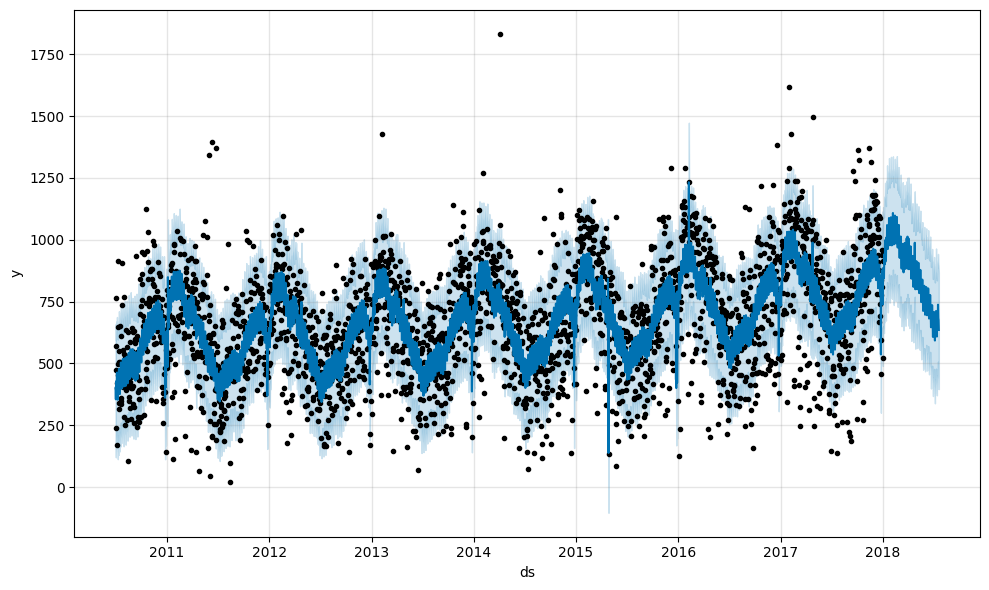

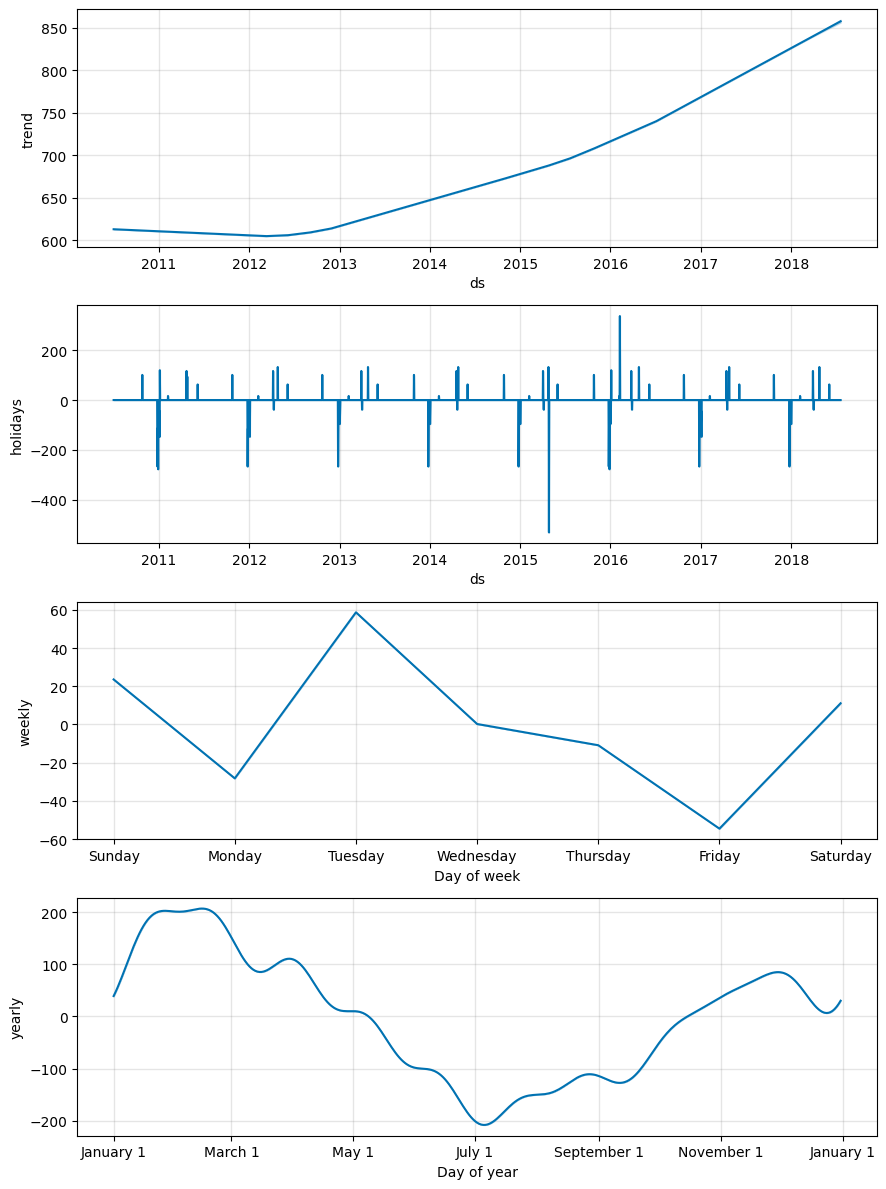

In [295]:
m = Prophet()
m.add_country_holidays(country_name='NZ') 


m.fit(train_forcast)

future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)

m.plot(forecast)
plt.show()

m.plot_components(forecast)
plt.show()


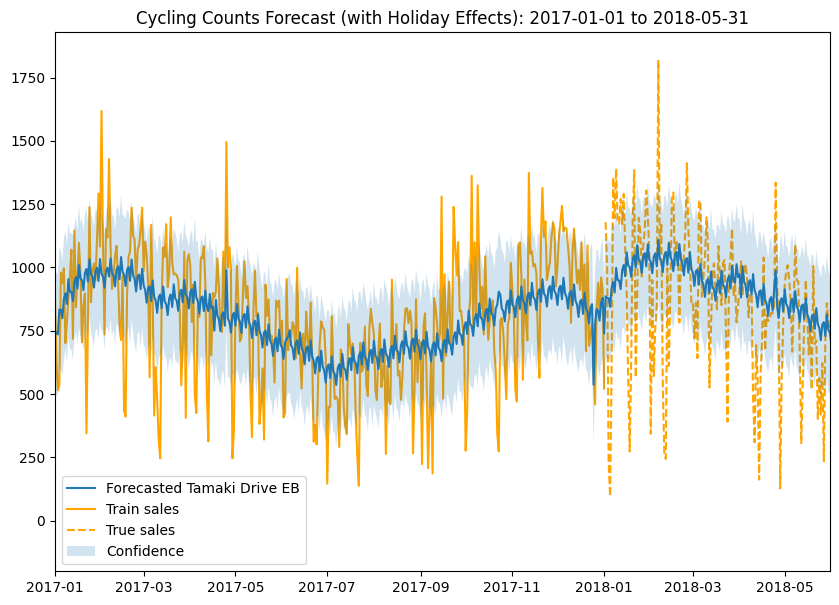

In [296]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Tamaki Drive EB', zorder=1)
plt.plot(train_data_plot['ds'], train_data_plot['y'], label='Train sales', zorder=0, color='orange')
plt.plot(test_data_plot['ds'], test_data_plot['y'], label='True sales', zorder=0, color='orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=0.2, label='Confidence')
plt.title('Cycling Counts Forecast (with Holiday Effects): 2017-01-01 to 2018-05-31')
plt.legend()
plt.xlim(pd.to_datetime(['2017-01-01', '2018-05-31']))
plt.show()


The trend shows a steady increase in cycling counts over the years.
The upward trend indicates growing popularity or increased use of cycling


In [297]:
holiday_effect = forecast[['ds', 'holidays']]
holiday_effect[holiday_effect['holidays'].abs() > 0].sort_values(by='holidays', ascending=False).head(15)


,ds,holidays
2048,2016-02-08,337.232728
2125,2016-04-25,132.639731
1029,2013-04-25,132.639731
1394,2014-04-25,132.639731
1759,2015-04-25,132.639731
664,2012-04-25,132.639731
2490,2017-04-25,132.639731
2855,2018-04-25,132.639731
187,2011-01-04,119.773595
2013,2016-01-04,119.773595


In [298]:
m.train_holiday_names


0                          New Year's Day
1                Day after New Year's Day
2     Day after New Year's Day (observed)
3                            Waitangi Day
4                 Waitangi Day (observed)
5                               Anzac Day
6                             Good Friday
7                           Easter Monday
8                        Queen's Birthday
9                              Labour Day
10                          Christmas Day
11               Christmas Day (observed)
12                             Boxing Day
13              New Year's Day (observed)
14                  Boxing Day (observed)
15                   Anzac Day (observed)
dtype: object

In [299]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Recreate test and train datasets if necessary
forecast_df = df.reset_index()[['datetime', 'Tamaki Drive EB']].rename(columns={'datetime': 'ds', 'Tamaki Drive EB': 'y'})
test_forecast = forecast_df[forecast_df['ds'] > '2018-01-01'].copy()
train_forecast = forecast_df[forecast_df['ds'] <= '2018-01-01'].copy()



# Merge forecasted and actual test data
forecast_eval = forecast[['ds', 'yhat']].merge(
    test_forecast[['ds', 'y']],
    on='ds',
    how='inner'
)

# Calculate metrics
mae = mean_absolute_error(forecast_eval['y'], forecast_eval['yhat'])
rmse = mean_squared_error(forecast_eval['y'], forecast_eval['yhat'], squared=False)  # RMSE
mape = np.mean(np.abs((forecast_eval['y'] - forecast_eval['yhat']) / forecast_eval['y'])) * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 203.47160959219002
Root Mean Squared Error (RMSE): 278.96629953975054
Mean Absolute Percentage Error (MAPE): 44.79%


Add Custom Holidays 

Include the holiday with a wider effect window (lower_window and upper_window) to account for before-and-after effects.


12:34:51 - cmdstanpy - INFO - Chain [1] start processing
12:34:51 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 203.50391966057535
Root Mean Squared Error (RMSE): 279.03804503647234
Mean Absolute Percentage Error (MAPE): 44.80%


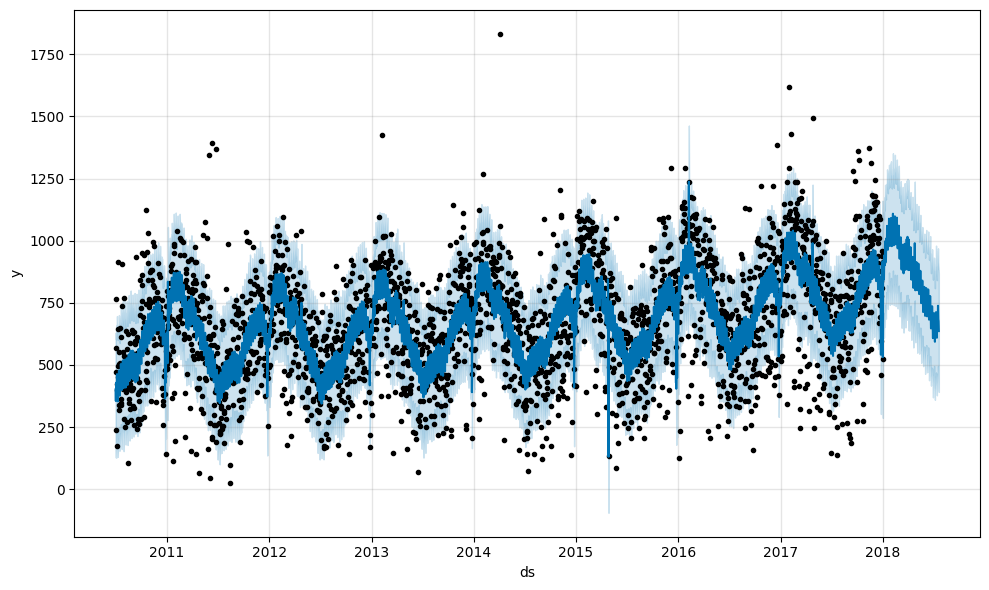

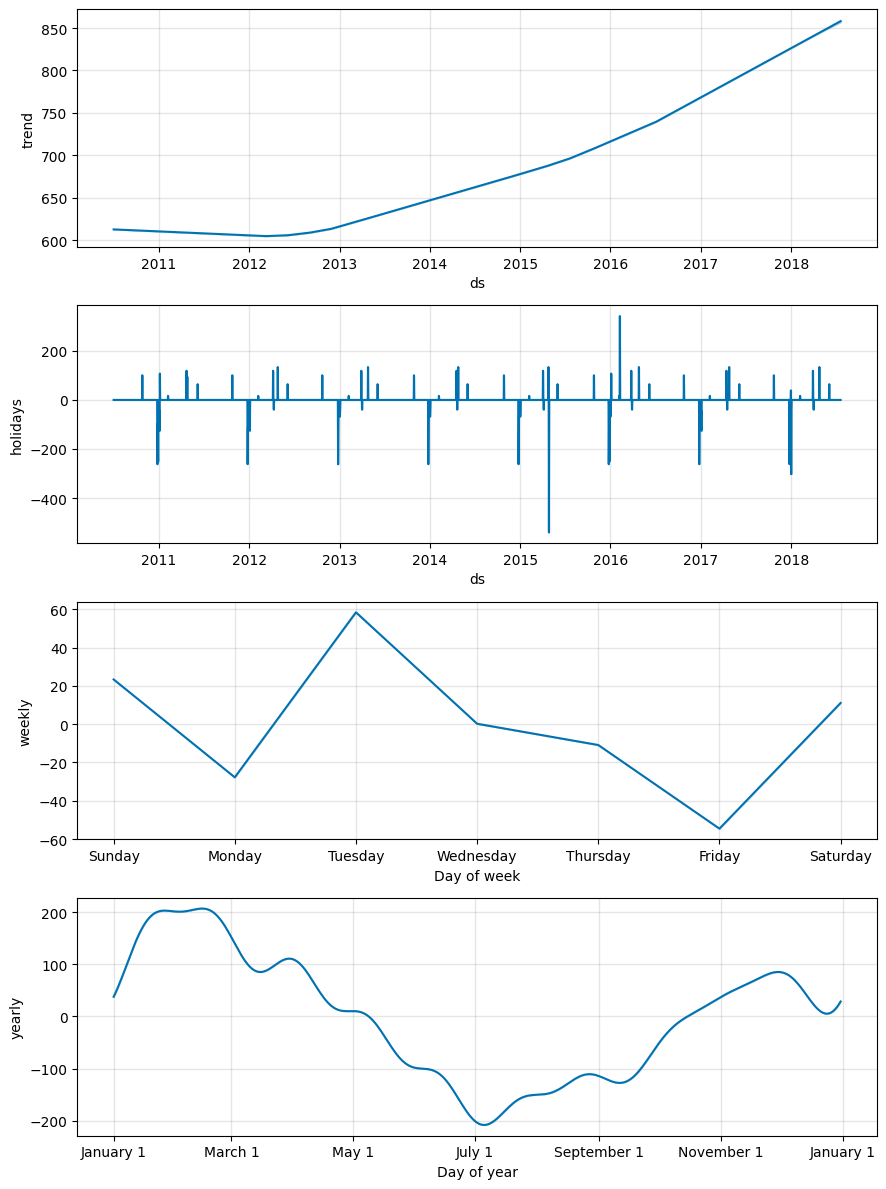

In [300]:


# Create a custom holiday DataFrame
custom_holidays = pd.DataFrame({
    'holiday': ['holiday_name'],
    'ds': pd.to_datetime(['2018-01-01']),
    'lower_window': -1,  # Day before the holiday
    'upper_window': 2    # Two days after the holiday
})

# Initialize Prophet model with both NZ holidays and custom holidays
m = Prophet(holidays=custom_holidays)
m.add_country_holidays(country_name='NZ')

# Fit the model on training data
m.fit(train_forecast)

# Create future dataframe and make predictions
future = m.make_future_dataframe(periods=200)
forecast = m.predict(future)

# Evaluate forecast accuracy
forecast_eval = forecast[['ds', 'yhat']].merge(
    test_forecast[['ds', 'y']],
    on='ds',
    how='inner'
)

# Calculate metrics
mae = mean_absolute_error(forecast_eval['y'], forecast_eval['yhat'])
rmse = mean_squared_error(forecast_eval['y'], forecast_eval['yhat'], squared=False)
mape = np.mean(np.abs((forecast_eval['y'] - forecast_eval['yhat']) / forecast_eval['y'])) * 100

# Print metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot the forecast and components
m.plot(forecast)
plt.show()

m.plot_components(forecast)
plt.show()


Load and Inspect Weather Data

In [301]:
weather_data = pd.read_csv('Auckland_weather_combined.csv', delimiter=';')

weather_data.rename(columns={'day': 'ds'}, inplace=True)
weather_data['ds'] = pd.to_datetime(weather_data['ds'])

weather_data.head()


,ds,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571


In [302]:
merged_data = forecast_df.merge(weather_data, on='ds', how='left')
merged_data.head()


,ds,y,sun,wind,rain,temp
0,2010-07-01,570.0,NaN,NaN,NaN,NaN
1,2010-07-02,473.0,NaN,NaN,NaN,NaN
2,2010-07-03,766.0,NaN,NaN,NaN,NaN
3,2010-07-04,240.0,NaN,NaN,NaN,NaN
4,2010-07-05,172.0,NaN,NaN,NaN,NaN


In [303]:
aligned_data = merged_data.dropna(subset=['sun', 'wind', 'rain', 'temp'])

print(f"Data starts on: {aligned_data['ds'].min()}")
print(f"Data ends on: {aligned_data['ds'].max()}")

print(f"Number of rows after trimming: {aligned_data.shape[0]}")


Data starts on: 2012-01-01 00:00:00
Data ends on: 2018-05-31 00:00:00
Number of rows after trimming: 2343


In [ ]:
# aligned_data for training and forecasting
forecast_df = aligned_data

test_forecast = forecast_df[forecast_df['ds'] > '2018-01-01'].copy()
train_forecast = forecast_df[forecast_df['ds'] <= '2018-01-01'].copy()


In [305]:
from prophet import Prophet

m = Prophet()

for regressor in ['sun', 'wind', 'rain', 'temp']:
    m.add_regressor(regressor)

m.fit(train_forecast)


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


In [306]:
future = m.make_future_dataframe(periods=200)

future = future.merge(weather_data, on='ds', how='left')

for column in ['sun', 'wind', 'rain', 'temp']:
    future[column].fillna(weather_data[column].mean(), inplace=True)


In [ ]:
forecast = m.predict(future)


forecast_eval = forecast[['ds', 'yhat']].merge(
    test_forecast[['ds', 'y']],
    on='ds',
    how='inner'
)

mae = mean_absolute_error(forecast_eval['y'], forecast_eval['yhat'])
rmse = mean_squared_error(forecast_eval['y'], forecast_eval['yhat'], squared=False)
mape = np.mean(np.abs((forecast_eval['y'] - forecast_eval['yhat']) / forecast_eval['y'])) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 122.77884778716177
Root Mean Squared Error (RMSE): 176.41582785404196
Mean Absolute Percentage Error (MAPE): 25.15%


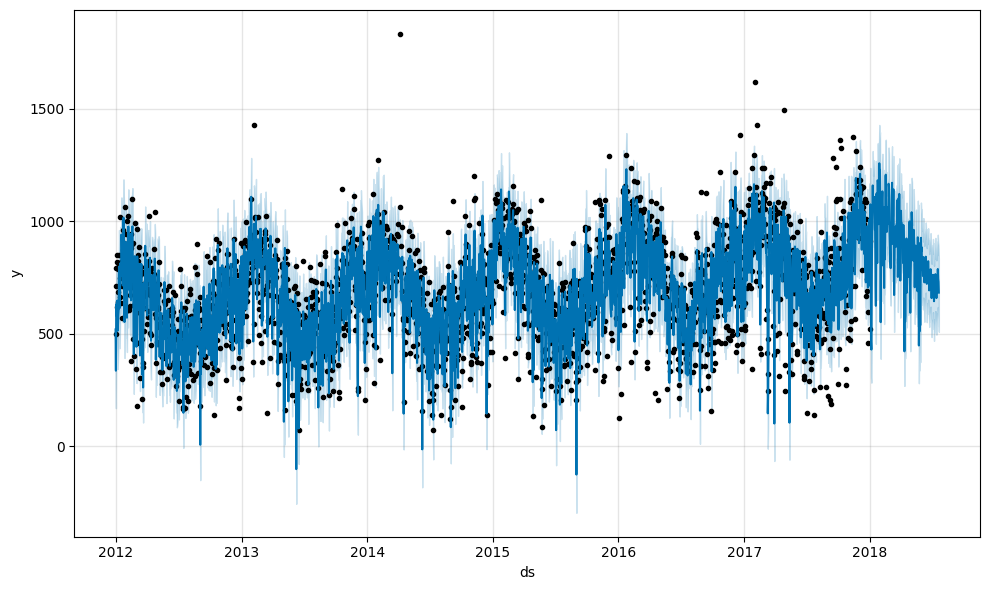

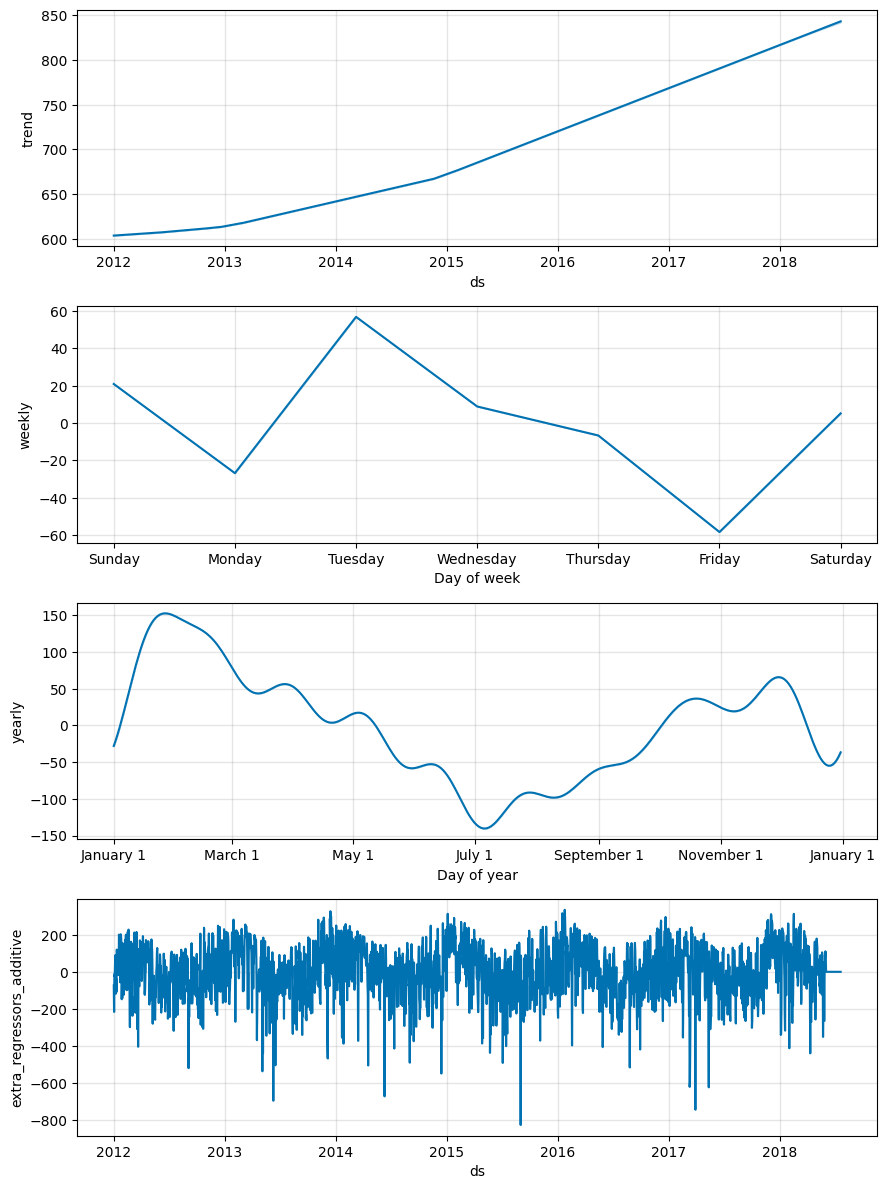

In [ ]:
fig1 = m.plot(forecast)
plt.show()

fig2 = m.plot_components(forecast)
plt.show()


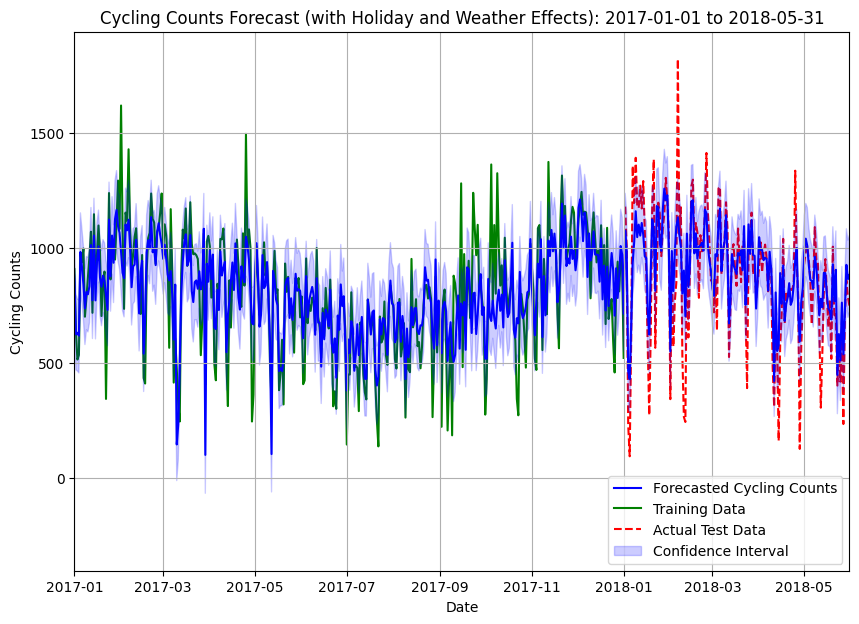

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cycling Counts', zorder=1, color='blue')

plt.plot(train_forecast['ds'], train_forecast['y'], label='Training Data', zorder=0, color='green')

plt.plot(test_forecast['ds'], test_forecast['y'], label='Actual Test Data', zorder=0, color='red', linestyle='dashed')

plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=0.2, label='Confidence Interval', color='blue')

plt.title('Cycling Counts Forecast (with Holiday and Weather Effects): 2017-01-01 to 2018-05-31')
plt.xlabel('Date')
plt.ylabel('Cycling Counts')
plt.legend()
plt.xlim(pd.to_datetime(['2017-01-01', '2018-05-31']))
plt.grid()

plt.show()


Evaluation Results After Adding Weather and Holiday Effects:
Mean Absolute Error (MAE):

Improved to 122.78 from 203.47 (original).
Indicates a significant reduction in the average prediction error.
Root Mean Squared Error (RMSE):

Improved to 176.42 from 279.04.
This indicates that the model now penalizes large errors less, suggesting better overall fit.
Mean Absolute Percentage Error (MAPE):

Improved to 25.15% from 44.80%.
Shows the model's predictions are much closer to actual values in percentage terms.


Key Takeaways:
Weather Effects Matter: Adding variables like sun, wind, rain, and temp significantly improved the forecast accuracy.




Further Practice:
I might read up on hyperparameter tuning for seasonality_mode in Forcasting.